## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [48]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [49]:
from sklearn.model_selection import train_test_split
df_trainval, df_test = train_test_split(df, test_size=0.2, random_state=1) #split train+val [80%], test [20%]
df_train, df_val = train_test_split(df_trainval, test_size=0.25, random_state=1) #split train[60%] val [20%]

#reset, drop index
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_test = np.log1p(df_test["price"]).values
y_train = np.log1p(df_train["price"]).values
y_val = np.log1p(df_val["price"]).values

del df_test["price"]
del df_train["price"]
del df_val["price"]

Now, use `DictVectorizer` to turn train and validation into matrices:

In [50]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False) #import encoder

# Serialize non-numerical data using DictVectorizer (aka One-Hot Encoding)
train_dict = df_train.to_dict(orient='records') # get categorial variables from train db, sort them by x and put them into dictionary 
X_train = dv.fit_transform(train_dict) #one-hot encoding 
val_dict = df_val.to_dict(orient='records') #apply same 
X_val = dv.transform(val_dict)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [51]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [52]:

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)
print(export_text(dt, feature_names=dv.get_feature_names()))


|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

Q1 --> room_type

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [53]:
from sklearn.ensemble import RandomForestRegressor

In [54]:
rf = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print("RMSE %2.3f" % np.sqrt(np.mean((y_pred-y_val)**2)) )

RMSE 0.462


What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

Q2--> 0.459

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [117]:
dfn = pd.DataFrame( columns = ['n_estim','val_rmse'])
for n_est in np.arange(10, 200, 10):
    rf = RandomForestRegressor(n_estimators=n_est, n_jobs=-1, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(np.mean((y_pred-y_val)**2))
    dfn = dfn.append( {'n_estim': n_est, 'val_rmse' : rmse}, ignore_index = True)

    

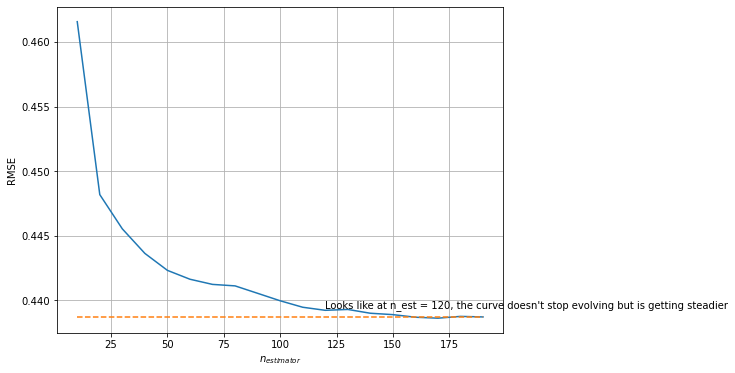

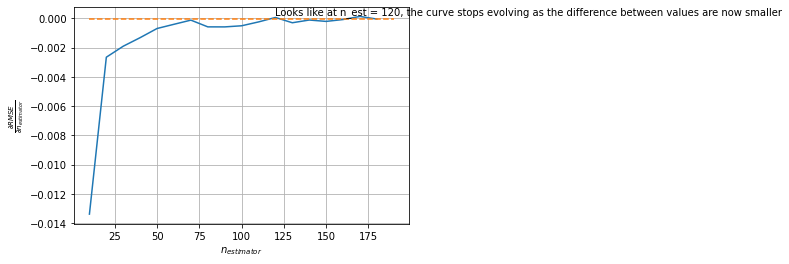

In [122]:
# RMSE vs estimation curve (ah yes, this was was leaked during last office hours)
plt.figure(figsize=(8,6))
plt.plot(dfn["n_estim"],dfn["val_rmse"])
plt.xlabel('$n_{estimator}$')
plt.xlabel('$n_{estimator}$')
plt.plot(dfn["n_estim"], np.ones(len(dfn)) * np.mean(dfn["val_rmse"][-5:]),'--', label='mean of the last 5 values')
plt.annotate("Looks like at n_est = 120, the curve doesn't stop evolving but is getting steadier", (dfn["n_estim"][11],dfn["val_rmse"][11]), xycoords='data',verticalalignment='bottom')
plt.ylabel('RMSE')
plt.grid()

# it doesn't look like it stops... a closer look says it evolves, but almost stops evolving starting from 120
#plt.figure(figsize=(8,6))
plt.figure()
#plt.semilogy(dfn["n_estim"][:-1],np.diff(dfn["val_rmse"])) #here means that if positive, then (1) it'll be shown and (2) the first value was higher
plt.plot(dfn["n_estim"][:-1],np.diff(dfn["val_rmse"])) 
plt.plot(dfn["n_estim"], np.ones(len(dfn)) * np.mean(np.diff(dfn["val_rmse"][-5:])),'--', label='mean of the diff of last 5 values')
plt.xlabel('$n_{estimator}$')
plt.xlabel('$n_{estimator}$')
plt.ylabel('$\\frac{\\partial RMSE}{\\partial n_{estimator}}$')
plt.annotate("Looks like at n_est = 120, the curve stops evolving as the difference between values are now smaller", (dfn["n_estim"][11],np.diff(dfn["val_rmse"][11:13])), xycoords='data',verticalalignment='bottom')
plt.grid()

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

Q3 --> 120

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [130]:
dfnm = pd.DataFrame( columns = ['n_estim','max_depth','val_rmse'])
for max_dep in [10, 15, 20, 25]:
    for n_est in np.arange(10, 200, 10):
        rf = RandomForestRegressor(n_estimators=n_est, max_depth=max_dep, n_jobs=-1, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = np.sqrt(np.mean((y_pred-y_val)**2))
        dfnm = dfnm.append( {'n_estim': n_est, 'max_depth': max_dep , 'val_rmse' : rmse}, ignore_index = True)

            

<AxesSubplot:xlabel='None-max_depth', ylabel='n_estim'>

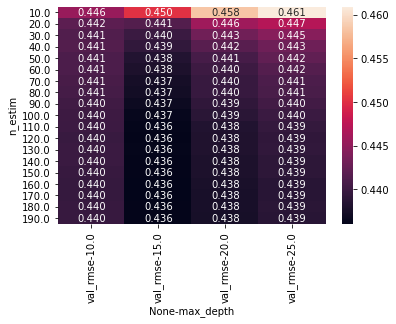

In [131]:
dfnm_pivot = dfnm.pivot(index='n_estim', columns=['max_depth'], values=['val_rmse'])
sns.heatmap(dfnm_pivot, annot=True, fmt=".3f")



In [132]:
# Can we put it as mean?
dfnm.groupby("max_depth").mean()

,n_estim,val_rmse
max_depth,,
10.0,100.0,0.440643
15.0,100.0,0.437941
20.0,100.0,0.440435
25.0,100.0,0.441725


What's the best `max_depth`:

* 10
* 15
* 20
* 25

Q4 --> 15


Bonus question (not graded):

Will the answer be different if we change the seed for the model?

In [133]:
dfnmr = pd.DataFrame( columns = ['random_seed','n_estim','max_depth','val_rmse'])
for srng in [1,2,3,4,5,6,7,8,9,10]: #just random rang ... say 10
    for max_dep in [10, 15, 20, 25]:
        for n_est in np.arange(10, 200, 10):
            rf = RandomForestRegressor(n_estimators=n_est, max_depth=max_dep, n_jobs=-1, random_state=srng)
            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_val)
            rmse = np.sqrt(np.mean((y_pred-y_val)**2))
            dfnmr = dfnmr.append( {'random_seed': srng, 'n_estim': n_est, 'max_depth': max_dep , 'val_rmse' : rmse}, ignore_index = True)
# interrupted due to computer overheat
            

KeyboardInterrupt: 

In [161]:
dfnmr.groupby(['random_seed','max_depth']).min().sort_values("val_rmse")["val_rmse"]
#dfnmr.groupby(['random_seed','max_depth']).min().sort_values("val_rmse")

random_seed  max_depth
3.0          15.0         0.435256
2.0          15.0         0.435408
5.0          15.0         0.435484
4.0          15.0         0.435751
7.0          15.0         0.435925
1.0          15.0         0.436047
6.0          15.0         0.436712
5.0          20.0         0.437105
3.0          20.0         0.437485
1.0          20.0         0.437587
2.0          20.0         0.437605
4.0          20.0         0.437716
5.0          25.0         0.438192
7.0          20.0         0.438227
2.0          25.0         0.438608
3.0          25.0         0.438637
6.0          20.0         0.438665
1.0          25.0         0.438696
4.0          25.0         0.438978
3.0          10.0         0.439312
2.0          10.0         0.439322
5.0          10.0         0.439334
7.0          10.0         0.439416
6.0          25.0         0.439566
1.0          10.0         0.439624
4.0          10.0         0.439713
6.0          10.0         0.440024
Name: val_rmse, dtype: float64

In [149]:
dfnmr.groupby(['max_depth']).quantile([0,0.5,1])

random_seed  n_estim  val_rmse
max_depth                                    
10.0      0.0          1.0     10.0  0.439312
          0.5          4.0    100.0  0.439855
          1.0          7.0    190.0  0.446494
15.0      0.0          1.0     10.0  0.435256
          0.5          4.0    100.0  0.436708
          1.0          7.0    190.0  0.452075
20.0      0.0          1.0     10.0  0.437105
          0.5          4.0    100.0  0.439095
          1.0          7.0    190.0  0.459963
25.0      0.0          1.0     10.0  0.438192
          0.5          3.5    100.0  0.440046
          1.0          6.0    190.0  0.462705

Unfortunately there is no sufficient data to answer this question. 
* For the first 7 srng, the answer remains the same.
* Looking at the quantile results shows a possible overlap, but the quantity of the data is too small to conclude: The result could be 10 or 20.
* Looking at srng = 5 and the next code cell shows that there is a high probability that at some big n_estimations, max_depth 20 could be a better solution 

Therefore: There is a possibility and this will be very narrow, there could be a random seed range to which the max_depth 20 will probably give better or similar results to max_depth 15 at a higher number of estimations. Again, this possibility is narrow seems to be narrow...

<AxesSubplot:xlabel='None-max_depth-random_seed', ylabel='n_estim'>

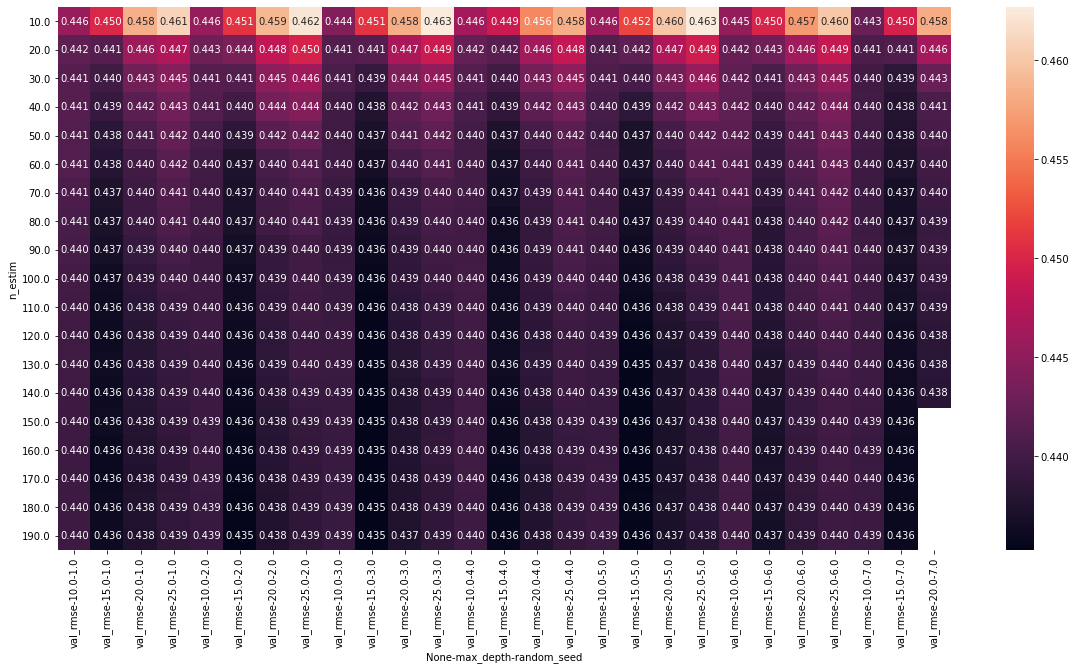

In [155]:
dfnmr.groupby(['max_depth']).quantile([0,0.5,1])
plt.figure(figsize=(20,10))
dfnmr_pivot = dfnmr.pivot(index='n_estim', columns=['max_depth','random_seed'], values=['val_rmse'])
sns.heatmap(dfnmr_pivot, annot=True, fmt=".3f")

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [179]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, n_jobs=-1, random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)


df_featimp = pd.DataFrame({'feature': dv.get_feature_names(), 'importance': rf.feature_importances_}).sort_values("importance",ascending=False)
df_featimp


,feature,importance
12,room_type=Entire home/apt,0.391898
3,longitude,0.154101
2,latitude,0.152775
0,availability_365,0.076264
11,reviews_per_month,0.054430
4,minimum_nights,0.053252
10,number_of_reviews,0.041594
7,neighbourhood_group=Manhattan,0.034047
1,calculated_host_listings_count,0.030102
14,room_type=Shared room,0.005023


What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

Q5 --> room_type=Entire home/apt

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [181]:
import pip
pip.main(['install','xgboost'])
import xgboost as xgb

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


  Using cached xgboost-1.4.2-py3-none-win_amd64.whl (97.8 MB)


In [201]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names = dv.get_feature_names())
dval = xgb.DMatrix(X_val,label=y_val, feature_names = dv.get_feature_names())

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

watchlist = [(dtrain, 'train'), (dval, 'val')]

In [206]:
#parser
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [234]:
%%capture output03
xgb_params['eta'] = 0.3;
model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=1, evals=watchlist)
df_score_03 = parse_xgb_output(output03)
df_score_03

In [235]:
%%capture output01
xgb_params['eta'] = 0.1;
model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=1, evals=watchlist)
df_score_01 = parse_xgb_output(output01)
df_score_01

In [237]:
%%capture output001
xgb_params['eta'] = 0.01;
model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=1, evals=watchlist)
df_score_001 = parse_xgb_output(output001)
df_score_001

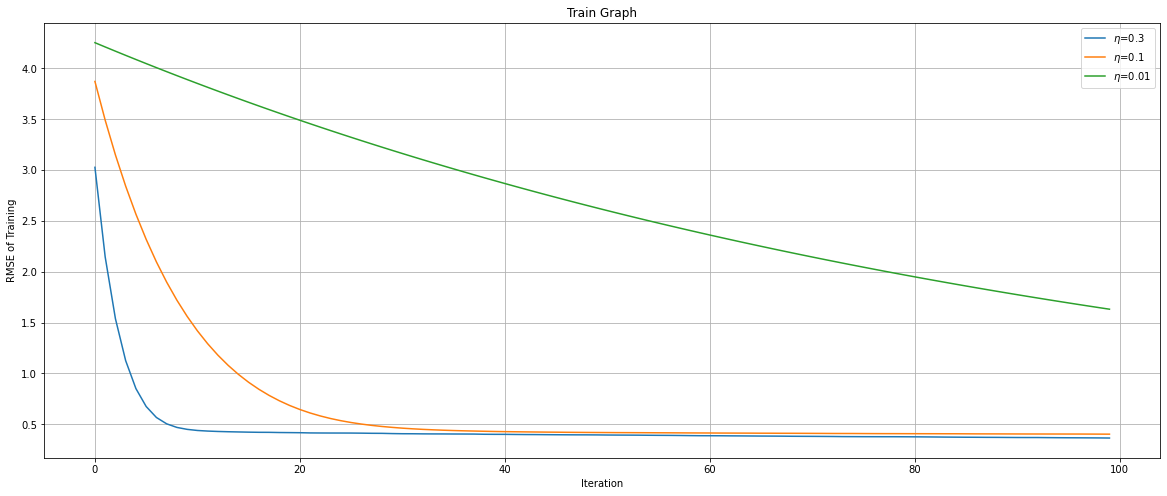

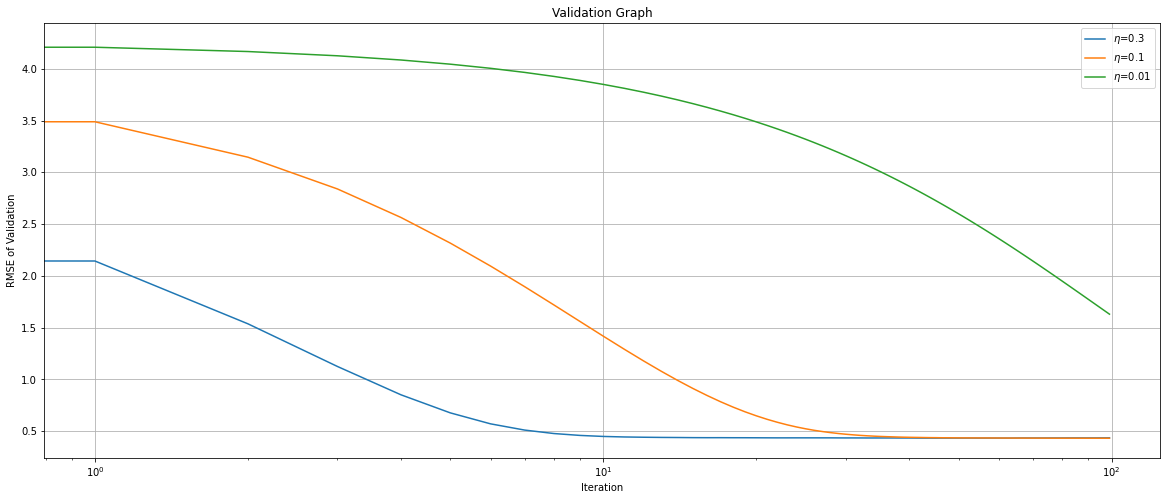

In [241]:

plt.figure(figsize=(20,8))
plt.plot(df_score_03.num_iter, df_score_03.train_rmse, label='$\\eta$=0.3')
plt.plot(df_score_01.num_iter, df_score_01.train_rmse, label='$\\eta$=0.1')
plt.plot(df_score_001.num_iter, df_score_001.train_rmse, label='$\\eta$=0.01')
plt.legend()
plt.title('Train Graph')
plt.xlabel('Iteration')
plt.ylabel('RMSE of Training')
plt.grid()
plt.show()

plt.figure(figsize=(20,8))
plt.plot(df_score_03.num_iter, df_score_03.val_rmse, label='$\\eta$=0.3')
plt.plot(df_score_01.num_iter, df_score_01.val_rmse, label='$\\eta$=0.1')
plt.plot(df_score_001.num_iter, df_score_001.val_rmse, label='$\\eta$=0.01')
#plt.xscale('log')
plt.legend()
plt.grid()
plt.title('Validation Graph')
plt.xlabel('Iteration')
plt.ylabel('RMSE of Validation')
plt.show()


Now change `eta` first to `0.1` and then to `0.01`

In [239]:
#0.3 and 0.1 give similar results, therefore, we will be resorting to exact maths
print('Validation of eta=0.3: %2.5f'% df_score_03.val_rmse[99])
print('Validation of eta=0.1: %2.5f'% df_score_01.val_rmse[99])
print('Validation of eta=0.01: %2.5f'% df_score_001.val_rmse[99])

Validation of eta=0.3: 0.43621
Validation of eta=0.1: 0.43250
Validation of eta=0.01: 1.63045


What's the best eta?

* 0.3
* 0.1
* 0.01

Q6 --> 0.1

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

